In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
df_new_unknowns = pd.read_csv('../CSV/df_new_unknowns.csv', low_memory=False)

df_new = pd.read_csv('../CSV/df_new.csv', low_memory=False)

df = pd.read_csv('../CSV/df.csv', low_memory=False)

# Set display option to show all columns
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

pd.set_option('display.width', None)

In [4]:
df_new

,NAICS_U.S._Industry_Title,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval
0,RetailTrade,84,4,New,Unknown,0,1,60000,1,Midwest,0,February
1,Accommodation_FoodServices,60,2,New,Unknown,0,1,40000,1,Midwest,0,February
2,HealthCare_SocialAssistance,180,7,Existing,Unknown,0,0,287000,1,Midwest,0,February
3,Unknown,60,2,Existing,Unknown,0,1,35000,1,South,0,February
4,Unknown,240,14,Existing,Unknown,0,0,229000,1,South,0,February
...,...,...,...,...,...,...,...,...,...,...,...,...
872914,RetailTrade,60,6,Existing,Unknown,0,0,70000,1,Midwest,0,February
872915,RetailTrade,60,6,Existing,Unknown,1,0,85000,1,Midwest,0,February
872916,Manufacturing,108,26,Existing,Unknown,0,0,300000,1,West,0,February
872917,Unknown,60,6,Existing,Unknown,0,1,75000,0,West,0,February


In [5]:
df_new_unknowns

,NAICS_U.S._Industry_Title,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval
0,RetailTrade,162,2,New,Urban,0,0,253400,1,South,1,February
1,Accommodation_FoodServices,126,7,Existing,Urban,0,0,137300,1,South,0,February
2,Educational,83,18,New,Urban,1,0,438541,1,West,0,February
3,Construction,84,4,Existing,Urban,1,0,51440,1,South,0,February
4,RealEstate_Rental_Leasing,60,3,Existing,Urban,0,0,50000,1,South,0,February
...,...,...,...,...,...,...,...,...,...,...,...,...
532521,Construction,240,20,Existing,Urban,0,0,509000,1,West,0,February
532522,Information,84,3,Existing,Urban,1,0,15635,1,West,0,February
532523,Accommodation_FoodServices,240,10,Existing,Urban,0,0,1038000,1,Midwest,0,February
532524,Manufacturing,107,2,Existing,Rural,0,0,170000,0,West,0,January


We will analyze two datasets to evaluate the impact of unknown values on our discriminant analysis model:
- **df_new:** The cleaned dataset where unknown values are retained.
- **df_new_unknowns:** The dataset with rows containing unknown values removed.

This comparison will help determine whether unknown values significantly affect model performance.

#### Dummy Encoding

We are using **dummy encoding** to transform categorical variables into numerical representations suitable for machine learning models. This process converts categories into binary (0 or 1) columns, allowing algorithms like discriminant analysis to process the data effectively. Dummy variables help maintain the interpretability of categorical data while ensuring compatibility with numerical modeling techniques.

**Why Certain Columns Are Excluded**

The following columns are excluded from dummy encoding:
- **Loan_Term**, **Number_Of_Employees**, **Disbursement_Gross**: These columns are numerical and do not require encoding.
- **Revolving_Line_Of_Credit**, **Low_Documentation_Loan_Program**: These columns already contain binary values (0 and 1) and do not need further transformation.
- **Loan_Status**: This column is the target variable (dependent variable) for our discriminant analysis model and should not be transformed.

By excluding these columns, we ensure that the essential structure of the data remains intact while focusing on converting only the necessary categorical features into dummy variables.

In [9]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_unknown_dummies = pd.get_dummies(df_new_unknowns, columns=[col for col in df_new_unknowns.columns if col not in exclude_columns], drop_first=True)

df_new_dummies = pd.get_dummies(df_new, columns=[col for col in df_new.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_unknown_dummies.select_dtypes(include=['bool']).columns:
    df_new_unknown_dummies[col] = df_new_unknown_dummies[col].astype(int)

for col in df_new_dummies.select_dtypes(include=['bool']).columns:
    df_new_dummies[col] = df_new_dummies[col].astype(int)

In [10]:
df_new_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,NAICS_U.S._Industry_Title_Administrative&Support_WasteManagement_RemediationServices,NAICS_U.S._Industry_Title_Agriculture_Forestry_Fishing_Hunting,NAICS_U.S._Industry_Title_Arts_Entertainment_Recreation,NAICS_U.S._Industry_Title_Construction,NAICS_U.S._Industry_Title_Educational,NAICS_U.S._Industry_Title_Finance_Insurance,NAICS_U.S._Industry_Title_HealthCare_SocialAssistance,NAICS_U.S._Industry_Title_Information,NAICS_U.S._Industry_Title_ManagementOfCompaniesAndEnterprises,NAICS_U.S._Industry_Title_Manufacturing,NAICS_U.S._Industry_Title_Mining_Quarrying_Oil&GasExtraction,NAICS_U.S._Industry_Title_OtherServices(except Public Administration),NAICS_U.S._Industry_Title_Professional_Scientific_TechService,NAICS_U.S._Industry_Title_PublicAdministration,NAICS_U.S._Industry_Title_RealEstate_Rental_Leasing,NAICS_U.S._Industry_Title_RetailTrade,NAICS_U.S._Industry_Title_Transportation_Warehousing,NAICS_U.S._Industry_Title_Unknown,NAICS_U.S._Industry_Title_Utilities,NAICS_U.S._Industry_Title_WholesaleTrade,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Franchise_Status_1,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,84,4,0,1,60000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,2,0,1,40000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,60,2,0,1,35000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,240,14,0,0,229000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
872917,60,6,0,1,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [11]:
df_new_unknown_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,NAICS_U.S._Industry_Title_Administrative&Support_WasteManagement_RemediationServices,NAICS_U.S._Industry_Title_Agriculture_Forestry_Fishing_Hunting,NAICS_U.S._Industry_Title_Arts_Entertainment_Recreation,NAICS_U.S._Industry_Title_Construction,NAICS_U.S._Industry_Title_Educational,NAICS_U.S._Industry_Title_Finance_Insurance,NAICS_U.S._Industry_Title_HealthCare_SocialAssistance,NAICS_U.S._Industry_Title_Information,NAICS_U.S._Industry_Title_ManagementOfCompaniesAndEnterprises,NAICS_U.S._Industry_Title_Manufacturing,NAICS_U.S._Industry_Title_Mining_Quarrying_Oil&GasExtraction,NAICS_U.S._Industry_Title_OtherServices(except Public Administration),NAICS_U.S._Industry_Title_Professional_Scientific_TechService,NAICS_U.S._Industry_Title_PublicAdministration,NAICS_U.S._Industry_Title_RealEstate_Rental_Leasing,NAICS_U.S._Industry_Title_RetailTrade,NAICS_U.S._Industry_Title_Transportation_Warehousing,NAICS_U.S._Industry_Title_Utilities,NAICS_U.S._Industry_Title_WholesaleTrade,Business_Type_New,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Franchise_Status_1,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,162,2,0,0,253400,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1,126,7,0,0,137300,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,83,18,1,0,438541,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,84,4,1,0,51440,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,60,3,0,0,50000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532521,240,20,0,0,509000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
532522,84,3,1,0,15635,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
532523,240,10,0,0,1038000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
532524,107,2,0,0,170000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


#### Linear Discriminant Analysis

We will perform **Linear Discriminant Analysis (LDA)** on two datasets to evaluate their performance and understand the impact of data handling techniques:
- **df_new_dummies:** A dataset with dummy variables created from categorical features, retaining unknown values.
- **df_new_unknown_dummies:** A dataset with dummy variables, but rows with unknown values have been removed.

**What is Linear Discriminant Analysis (LDA)?**

Linear Discriminant Analysis is a classification technique that models the relationship between predictors and a categorical response variable by assuming distinct classes follow a multivariate normal distribution with equal covariance matrices. Key features include:
- **Objective:** Maximize the separation between classes by projecting data onto a linear subspace while minimizing intra-class variation.
- **Assumptions:** Predictors are normally distributed and classes share the same covariance structure.

**Goals of the Analysis:**
- Compare the accuracy and performance metrics of LDA across the two datasets.
- Assess how retaining or removing unknown values influences the results.
- Evaluate the effectiveness of LDA in handling the structure and characteristics of the given data.

This analysis will provide insights into the impact of preprocessing decisions on the performance of linear discriminant models.

Training Set Metrics:
Accuracy: 0.8327
Precision: 0.8176
Recall: 0.8327
F1 Score: 0.7640

Test Set Metrics:
Accuracy: 0.8329
Precision: 0.8191
Recall: 0.8329
F1 Score: 0.7639

Specificity (Training Set): 0.0345
Specificity (Test Set): 0.0333


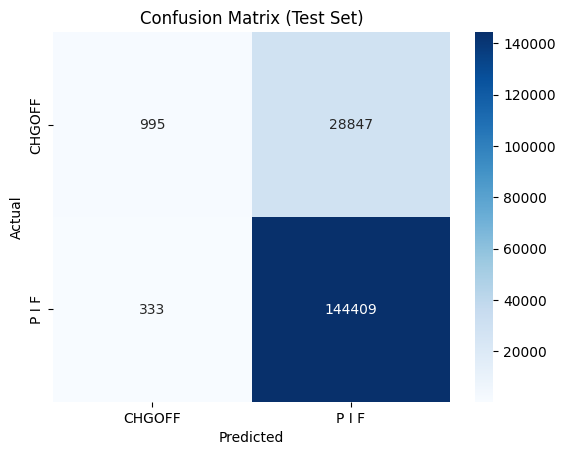

Total Net Profit/Loss: 578984058.50
Average Total Net Profit/Loss: 3316.36


In [14]:
# Step 1: Split Data into Features and Labels
X = df_new_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = lda.predict(X_train_scaled)
y_test_pred = lda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets

# For training set
cm_train = confusion_matrix(y_train, y_train_pred)  # Compute confusion matrix for training set
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)  # Compute confusion matrix for test set
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')  # X-axis label
plt.ylabel('Actual')  # Y-axis label
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Training Set Metrics:
Accuracy: 0.7835
Precision: 0.7673
Recall: 0.7835
F1 Score: 0.7186

Test Set Metrics:
Accuracy: 0.7823
Precision: 0.7654
Recall: 0.7823
F1 Score: 0.7174

Specificity (Training Set): 0.1189
Specificity (Test Set): 0.1192


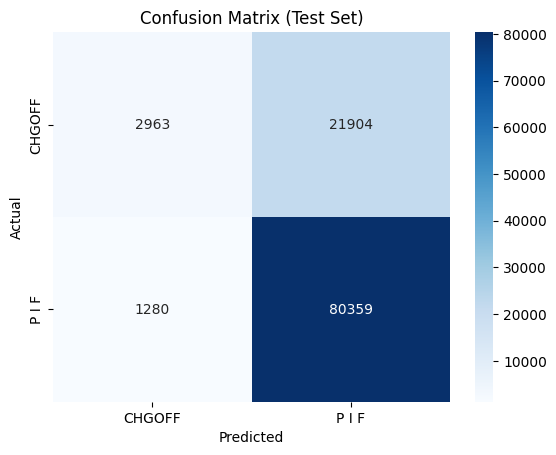

Total Net Profit/Loss: -186342126.55
Average Total Net Profit/Loss: -1749.59


In [15]:
# Step 1: Split Data into Features and Labels
X = df_new_unknown_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_unknown_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = lda.predict(X_train_scaled)
y_test_pred = lda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets

# For training set
cm_train = confusion_matrix(y_train, y_train_pred)  # Compute confusion matrix for training set
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)  # Compute confusion matrix for test set
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')  # X-axis label
plt.ylabel('Actual')  # Y-axis label
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

The analysis compared the performance of Linear Discriminant Analysis (LDA) on two datasets: **df_new_dummies** (retaining unknown values) and **df_new_unknown_dummies** (removing rows with unknown values).
- **df_new_dummies** outperformed **df_new_unknown_dummies** across all key metrics, including accuracy, precision, recall, F1 score, and specificity on both training and test sets.
- **df_new_unknown_dummies** exhibited notably lower specificity and overall performance.
- The removal of rows with unknown values not only weakened model performance but also resulted in a negative net profit.

#### Adding Weights to Linear Discriminant Analysis (LDA) for Improved Class Handling

In this section, we will incorporate **sample weights** to account for class imbalances during model training. These weights will adjust the impact of each sample on the learning process, ensuring that minority classes are given more consideration. The goal is to improve the model's performance by assigning appropriate weights to different classes, leading to better decision boundaries for imbalanced datasets.

In [19]:
# Replace with your actual data
y = df_new_dummies['Loan_Status']

# Calculate the total number of instances
total_instances = len(y)

# Calculate the count of each class
class_counts = y.value_counts()

# Get the counts for each class
class_0_count = class_counts[0]  # Count for class 0
class_1_count = class_counts[1]  # Count for class 1

# Calculate the proportions for each class
p0 = class_0_count / total_instances  # Proportion for class 0
p1 = class_1_count / total_instances  # Proportion for class 1

# Calculate weights as the inverse of proportions (if balancing)
w0 = 1 / p0  # Weight for class 0
w1 = 1 / p1  # Weight for class 1

# Normalize weights (optional, so they sum to 1)
sum_weights = w0 + w1
normalized_w0 = w0 / sum_weights
normalized_w1 = w1 / sum_weights

# Print results
print(f"Class 0 count: {class_0_count}")
print(f"Class 1 count: {class_1_count}")
print(f"Proportion for class 0 (p0): {p0:.4f}")
print(f"Proportion for class 1 (p1): {p1:.4f}")
print(f"Weight for class 0 (w0): {w0:.4f}")
print(f"Weight for class 1 (w1): {w1:.4f}")
print(f"Normalized weight for class 0: {normalized_w0:.4f}")
print(f"Normalized weight for class 1: {normalized_w1:.4f}")

Class 0 count: 149379
Class 1 count: 723540
Proportion for class 0 (p0): 0.1711
Proportion for class 1 (p1): 0.8289
Weight for class 0 (w0): 5.8437
Weight for class 1 (w1): 1.2065
Normalized weight for class 0: 0.8289
Normalized weight for class 1: 0.1711


Training Set Metrics:
Accuracy: 0.3360
Precision: 0.8455
Recall: 0.3360
F1 Score: 0.3364

Test Set Metrics:
Accuracy: 0.3354
Precision: 0.8441
Recall: 0.3354
F1 Score: 0.3362

Specificity (Training Set): 0.9782
Specificity (Test Set): 0.9763


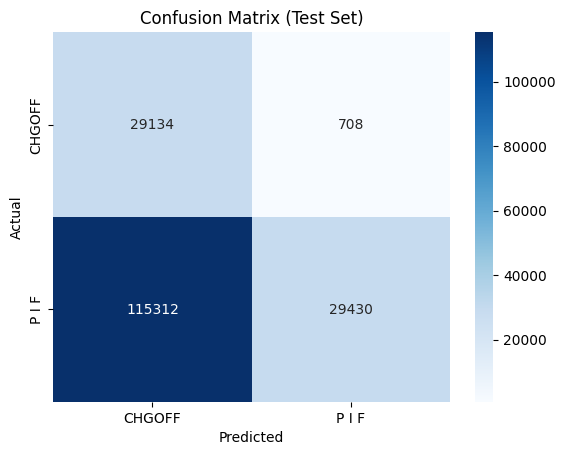

Total Net Profit/Loss: 483171493.40000004
Average Total Net Profit/Loss: 2767.55884502589


In [20]:
# Step 1: Split Data into Features and Labels
X = df_new_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform LDA with Weights (Class Priors)
# Here, [0.8153, 0.1847] are the class prior probabilities for the two classes.
lda = LinearDiscriminantAnalysis(priors=[normalized_w0, normalized_w1])  
lda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = lda.predict(X_train_scaled)
y_test_pred = lda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets

# For training set
cm_train = confusion_matrix(y_train, y_train_pred)  # Compute confusion matrix for training set
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)  # Specificity for training set

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)  # Compute confusion matrix for test set
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)  # Specificity for test set

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')  # X-axis label
plt.ylabel('Actual')  # Y-axis label
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df_new.join(results)

# Assuming you want to apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net}")

In [21]:
# Replace with your actual data
y = df_new_unknown_dummies['Loan_Status']

# Calculate the total number of instances
total_instances = len(y)

# Calculate the count of each class
class_counts = y.value_counts()

# Get the counts for each class
class_0_count = class_counts[0]  # Count for class 0
class_1_count = class_counts[1]  # Count for class 1

# Calculate the proportions for each class
p0 = class_0_count / total_instances  # Proportion for class 0
p1 = class_1_count / total_instances  # Proportion for class 1

# Calculate weights as the inverse of proportions (if balancing)
w0 = 1 / p0  # Weight for class 0
w1 = 1 / p1  # Weight for class 1

# Normalize weights (optional, so they sum to 1)
sum_weights = w0 + w1
normalized_w0 = w0 / sum_weights
normalized_w1 = w1 / sum_weights

# Print results
print(f"Class 0 count: {class_0_count}")
print(f"Class 1 count: {class_1_count}")
print(f"Proportion for class 0 (p0): {p0:.4f}")
print(f"Proportion for class 1 (p1): {p1:.4f}")
print(f"Weight for class 0 (w0): {w0:.4f}")
print(f"Weight for class 1 (w1): {w1:.4f}")
print(f"Normalized weight for class 0: {normalized_w0:.4f}")
print(f"Normalized weight for class 1: {normalized_w1:.4f}")

Class 0 count: 123929
Class 1 count: 408597
Proportion for class 0 (p0): 0.2327
Proportion for class 1 (p1): 0.7673
Weight for class 0 (w0): 4.2970
Weight for class 1 (w1): 1.3033
Normalized weight for class 0: 0.7673
Normalized weight for class 1: 0.2327


Training Set Metrics:
Accuracy: 0.3753
Precision: 0.7998
Recall: 0.3753
F1 Score: 0.3454

Test Set Metrics:
Accuracy: 0.3781
Precision: 0.8010
Recall: 0.3781
F1 Score: 0.3486

Specificity (Training Set): 0.9740
Specificity (Test Set): 0.9751


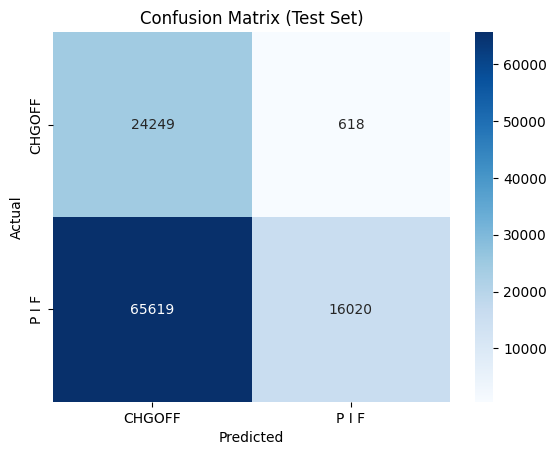

Total Net Profit/Loss: 142605585.84999993
Average Total Net Profit/Loss: 1338.9441519726581


In [22]:
# Step 1: Split Data into Features and Labels
X = df_new_unknown_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_unknown_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform LDA with Weights (Class Priors)
# Here, [0.8153, 0.1847] are the class prior probabilities for the two classes.
lda = LinearDiscriminantAnalysis(priors=[normalized_w0, normalized_w1])  
lda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = lda.predict(X_train_scaled)
y_test_pred = lda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets

# For training set
cm_train = confusion_matrix(y_train, y_train_pred)  # Compute confusion matrix for training set
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)  # Specificity for training set

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)  # Compute confusion matrix for test set
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)  # Specificity for test set

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')  # X-axis label
plt.ylabel('Actual')  # Y-axis label
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df_new.join(results)

# Assuming you want to apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net}")

After applying class weights, we observe significant changes in the model's performance:
- **Specificity Increase:** Specificity improved notably, with values rising from 0.9782 (Training) to 0.9763 (Test) in **df_new_dummies**, and from 0.9740 (Training) to 0.9751 (Test) in **df_new_unknown_dummies**. This indicates that the model is better at correctly identifying negative cases (i.e., non-defaults).
- **Decline in Other Metrics:** While specificity improved, the key metrics such as accuracy, precision, recall, and F1 score saw a sharp decline. The **df_new_dummies** model dropped to an accuracy of 0.3354 (Test), and precision and recall also fell significantly.
- **Profit Impact:** The decline in overall performance, especially in precision and recall, leads to a reduction in profit. The model becomes less accurate at predicting defaults, which in turn reduces the potential for correct profit generation (correctly predicting loans paid in full), resulting in lower overall profit.

In summary, while specificity increased, the overall model performance deteriorated, reflecting the trade-off between balancing class weights and maintaining the accuracy and predictive power of the model.

#### Quadratic Discriminant Analysis

For this analysis, we will focus solely on **df_new_dummies** as it has yielded the best overall metrics in terms of accuracy, precision, recall, and F1 score, despite the trade-offs observed in specificity.

Next, we will apply **Quadratic Discriminant Analysis (QDA)**, a powerful classification technique that goes beyond Linear Discriminant Analysis (LDA).

- **Covariance Flexibility:** Unlike Linear Discriminant Analysis (LDA), which assumes that all classes share the same covariance matrix, QDA allows each class to have its own covariance structure.
- **Modeling Complex Boundaries:** This flexibility enables QDA to model more complex decision boundaries, making it well-suited for cases where classes have different variances or are not linearly separable.

By applying QDA, we aim to investigate if the model's flexibility can improve classification performance on the **df_new_dummie** dataset.

Training Set Metrics:
Accuracy: 0.6514
Precision: 0.8082
Recall: 0.6514
F1 Score: 0.6940

Test Set Metrics:
Accuracy: 0.6527
Precision: 0.8095
Recall: 0.6527
F1 Score: 0.6952

Specificity (Training Set): 0.7137
Specificity (Test Set): 0.7171


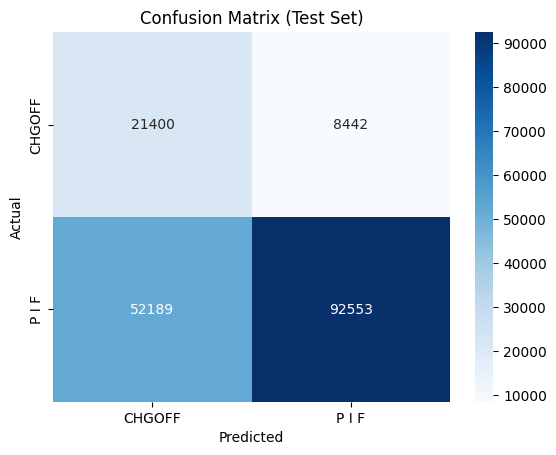

Total Net Profit/Loss: 750419510.15
Average Total Net Profit/Loss: 4298.33


In [26]:
# Step 1: Split Data into Features and Labels
X = df_new_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

The **quadratic discriminant analysis (QDA)** model shows significant improvements in performance compared to both the **linear discriminant analysis (LDA) model** and **LDA with weights**, providing more accurate and financially beneficial predictions.

This model offers substantial improvements over linear models, enhancing both profitability and risk management in loan decision-making.

#### Improving Quadratic Discriminant Analysis Model for Better Accuracy and Profitability

After evaluating several models, **Quadratic Discriminant Analysis (QDA)** has emerged as the most optimal model based on its superior metrics. This model will now serve as the foundation for further experimentation.

To refine the model, we plan to systematically **experiment with variations of the dataset** by selectively removing certain features (columns). This step aims to analyze the impact of each feature on the model's performance and assess whether a simpler dataset can achieve even **better evaluation metrics** (accuracy, precision, recall, F1 score) and **maximize net profit**.

Through this iterative process, we aim to:
1. Identify key features that contribute the most to predictive accuracy and profitability.
2. Reduce potential overfitting by eliminating irrelevant or redundant features.
3. Enhance the interpretability of the model while maintaining or improving its performance.

The results of these experiments will guide the selection of the final dataset and ensure the QDA model operates at its highest potential.

##### Statistical Significance of QDA Model Coefficients

In [31]:
# Step 1: Add an intercept (constant) term to the features
X_train_const = sm.add_constant(X_train)  # This automatically adds the constant term to your features

# Step 2: Fit a logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Step 3: Get the summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.359199
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:               698335
Model:                          Logit   Df Residuals:                   698290
Method:                           MLE   Df Model:                           44
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.2153
Time:                        18:51:20   Log-Likelihood:            -2.5084e+05
converged:                       True   LL-Null:                   -3.1966e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------

We will experiment with dropping the columns **'Month_Of_Approval'**, **'NAICS_U.S._Industry_Title'**, and **'Franchise_Status'**. These features have high p-values, indicating lower statistical significance in the model. By excluding them, we aim to evaluate whether the model's metrics and net profit can be improved while maintaining its overall performance.

##### QDA: Removing NAICS

In this section, we analyze the performance of the **Quadratic Discriminant Analysis (QDA)** model after removing the **'NAICS_U.S._Industry_Title'** feature from the dataset. This experiment aims to assess the feature's impact on model performance and profitability metrics. By excluding NAICS, we aim to evaluate whether simplifying the dataset improves the model's effectiveness and business value.

In [35]:
df_new_naics = df_new.drop(columns = 'NAICS_U.S._Industry_Title')

In [36]:
df_new_naics

,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status,Month_Of_Approval
0,84,4,New,Unknown,0,1,60000,1,Midwest,0,February
1,60,2,New,Unknown,0,1,40000,1,Midwest,0,February
2,180,7,Existing,Unknown,0,0,287000,1,Midwest,0,February
3,60,2,Existing,Unknown,0,1,35000,1,South,0,February
4,240,14,Existing,Unknown,0,0,229000,1,South,0,February
...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,Existing,Unknown,0,0,70000,1,Midwest,0,February
872915,60,6,Existing,Unknown,1,0,85000,1,Midwest,0,February
872916,108,26,Existing,Unknown,0,0,300000,1,West,0,February
872917,60,6,Existing,Unknown,0,1,75000,0,West,0,February


In [37]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_naics_dummies = pd.get_dummies(df_new_naics, columns=[col for col in df_new_naics.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_naics_dummies.select_dtypes(include=['bool']).columns:
    df_new_naics_dummies[col] = df_new_naics_dummies[col].astype(int)

In [38]:
df_new_naics_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Franchise_Status_1,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,84,4,0,1,60000,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,2,0,1,40000,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,60,2,0,1,35000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,240,14,0,0,229000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
872917,60,6,0,1,75000,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


Training Set Metrics:
Accuracy: 0.6548
Precision: 0.8129
Recall: 0.6548
F1 Score: 0.6971

Test Set Metrics:
Accuracy: 0.6555
Precision: 0.8142
Recall: 0.6555
F1 Score: 0.6978

Specificity (Training Set): 0.7304
Specificity (Test Set): 0.7345


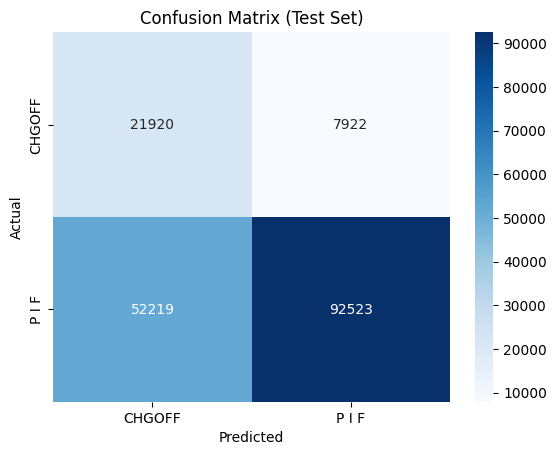

Total Net Profit/Loss: 774552801.00
Average Total Net Profit/Loss: 4436.56


In [39]:
# Step 1: Split Data into Features and Labels
X = df_new_naics_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_naics_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Removing the NAICS code feature improved the QDA model's overall performance, achieving strong metrics and significantly increasing net profit. This adjustment demonstrates the potential for streamlined datasets to enhance both predictive accuracy and economic outcomes.

##### QDA: Removing Month

In this section, we will evaluate the effect of removing the **'Month_Of_Approval'** feature from the QDA model. We'll compare the resulting metrics and profit to determine whether its exclusion improves or hinders the model's performance.

In [43]:
df_new_month = df_new.drop(columns = 'Month_Of_Approval')

In [44]:
df_new_month

,NAICS_U.S._Industry_Title,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Franchise_Status
0,RetailTrade,84,4,New,Unknown,0,1,60000,1,Midwest,0
1,Accommodation_FoodServices,60,2,New,Unknown,0,1,40000,1,Midwest,0
2,HealthCare_SocialAssistance,180,7,Existing,Unknown,0,0,287000,1,Midwest,0
3,Unknown,60,2,Existing,Unknown,0,1,35000,1,South,0
4,Unknown,240,14,Existing,Unknown,0,0,229000,1,South,0
...,...,...,...,...,...,...,...,...,...,...,...
872914,RetailTrade,60,6,Existing,Unknown,0,0,70000,1,Midwest,0
872915,RetailTrade,60,6,Existing,Unknown,1,0,85000,1,Midwest,0
872916,Manufacturing,108,26,Existing,Unknown,0,0,300000,1,West,0
872917,Unknown,60,6,Existing,Unknown,0,1,75000,0,West,0


In [45]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_month_dummies = pd.get_dummies(df_new_month, columns=[col for col in df_new_month.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_month_dummies.select_dtypes(include=['bool']).columns:
    df_new_month_dummies[col] = df_new_month_dummies[col].astype(int)

In [46]:
df_new_month_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,NAICS_U.S._Industry_Title_Administrative&Support_WasteManagement_RemediationServices,NAICS_U.S._Industry_Title_Agriculture_Forestry_Fishing_Hunting,NAICS_U.S._Industry_Title_Arts_Entertainment_Recreation,NAICS_U.S._Industry_Title_Construction,NAICS_U.S._Industry_Title_Educational,NAICS_U.S._Industry_Title_Finance_Insurance,NAICS_U.S._Industry_Title_HealthCare_SocialAssistance,NAICS_U.S._Industry_Title_Information,NAICS_U.S._Industry_Title_ManagementOfCompaniesAndEnterprises,NAICS_U.S._Industry_Title_Manufacturing,NAICS_U.S._Industry_Title_Mining_Quarrying_Oil&GasExtraction,NAICS_U.S._Industry_Title_OtherServices(except Public Administration),NAICS_U.S._Industry_Title_Professional_Scientific_TechService,NAICS_U.S._Industry_Title_PublicAdministration,NAICS_U.S._Industry_Title_RealEstate_Rental_Leasing,NAICS_U.S._Industry_Title_RetailTrade,NAICS_U.S._Industry_Title_Transportation_Warehousing,NAICS_U.S._Industry_Title_Unknown,NAICS_U.S._Industry_Title_Utilities,NAICS_U.S._Industry_Title_WholesaleTrade,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Franchise_Status_1
0,84,4,0,1,60000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,60,2,0,1,40000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,60,2,0,1,35000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
4,240,14,0,0,229000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
872917,60,6,0,1,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


Training Set Metrics:
Accuracy: 0.6512
Precision: 0.8079
Recall: 0.6512
F1 Score: 0.6938

Test Set Metrics:
Accuracy: 0.6520
Precision: 0.8089
Recall: 0.6520
F1 Score: 0.6946

Specificity (Training Set): 0.7128
Specificity (Test Set): 0.7154


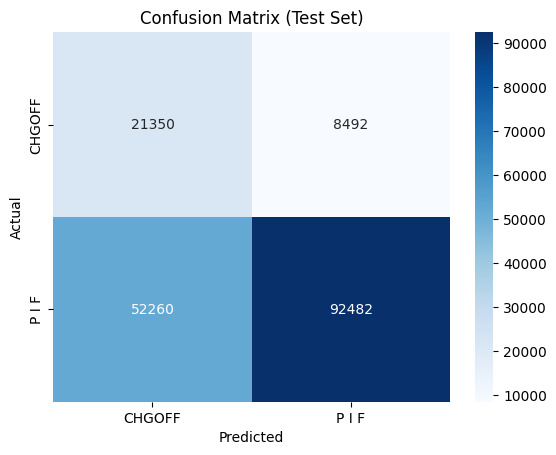

Total Net Profit/Loss: 746819203.35
Average Total Net Profit/Loss: 4277.71


In [47]:
# Step 1: Split Data into Features and Labels
X = df_new_month_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_month_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

The original QDA model demonstrated slightly higher profit while maintaining identical evaluation metrics compared to the model where the **'Month_Of_Approval'** feature was removed. This highlights the marginal impact of excluding **'Month_Of_Approval'** on the overall model performance and profitability.

##### QDA: Removing Franchise Status

In this section, we will evaluate the effect of removing the **'Franchise_Status'** feature from the QDA model. We'll compare the resulting metrics and profit to determine whether its exclusion improves or hinders the model's performance.

In [51]:
df_new_franchise = df_new.drop(columns = 'Franchise_Status')

In [52]:
df_new_franchise

,NAICS_U.S._Industry_Title,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region,Month_Of_Approval
0,RetailTrade,84,4,New,Unknown,0,1,60000,1,Midwest,February
1,Accommodation_FoodServices,60,2,New,Unknown,0,1,40000,1,Midwest,February
2,HealthCare_SocialAssistance,180,7,Existing,Unknown,0,0,287000,1,Midwest,February
3,Unknown,60,2,Existing,Unknown,0,1,35000,1,South,February
4,Unknown,240,14,Existing,Unknown,0,0,229000,1,South,February
...,...,...,...,...,...,...,...,...,...,...,...
872914,RetailTrade,60,6,Existing,Unknown,0,0,70000,1,Midwest,February
872915,RetailTrade,60,6,Existing,Unknown,1,0,85000,1,Midwest,February
872916,Manufacturing,108,26,Existing,Unknown,0,0,300000,1,West,February
872917,Unknown,60,6,Existing,Unknown,0,1,75000,0,West,February


In [53]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_franchise_dummies = pd.get_dummies(df_new_franchise, columns=[col for col in df_new_franchise.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_franchise_dummies.select_dtypes(include=['bool']).columns:
    df_new_franchise_dummies[col] = df_new_franchise_dummies[col].astype(int)

In [54]:
df_new_franchise_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,NAICS_U.S._Industry_Title_Administrative&Support_WasteManagement_RemediationServices,NAICS_U.S._Industry_Title_Agriculture_Forestry_Fishing_Hunting,NAICS_U.S._Industry_Title_Arts_Entertainment_Recreation,NAICS_U.S._Industry_Title_Construction,NAICS_U.S._Industry_Title_Educational,NAICS_U.S._Industry_Title_Finance_Insurance,NAICS_U.S._Industry_Title_HealthCare_SocialAssistance,NAICS_U.S._Industry_Title_Information,NAICS_U.S._Industry_Title_ManagementOfCompaniesAndEnterprises,NAICS_U.S._Industry_Title_Manufacturing,NAICS_U.S._Industry_Title_Mining_Quarrying_Oil&GasExtraction,NAICS_U.S._Industry_Title_OtherServices(except Public Administration),NAICS_U.S._Industry_Title_Professional_Scientific_TechService,NAICS_U.S._Industry_Title_PublicAdministration,NAICS_U.S._Industry_Title_RealEstate_Rental_Leasing,NAICS_U.S._Industry_Title_RetailTrade,NAICS_U.S._Industry_Title_Transportation_Warehousing,NAICS_U.S._Industry_Title_Unknown,NAICS_U.S._Industry_Title_Utilities,NAICS_U.S._Industry_Title_WholesaleTrade,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West,Month_Of_Approval_August,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
0,84,4,0,1,60000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60,2,0,1,40000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,180,7,0,0,287000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,60,2,0,1,35000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,240,14,0,0,229000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872915,60,6,1,0,85000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
872916,108,26,0,0,300000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
872917,60,6,0,1,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


Training Set Metrics:
Accuracy: 0.6497
Precision: 0.8079
Recall: 0.6497
F1 Score: 0.6925

Test Set Metrics:
Accuracy: 0.6506
Precision: 0.8089
Recall: 0.6506
F1 Score: 0.6934

Specificity (Training Set): 0.7143
Specificity (Test Set): 0.7169


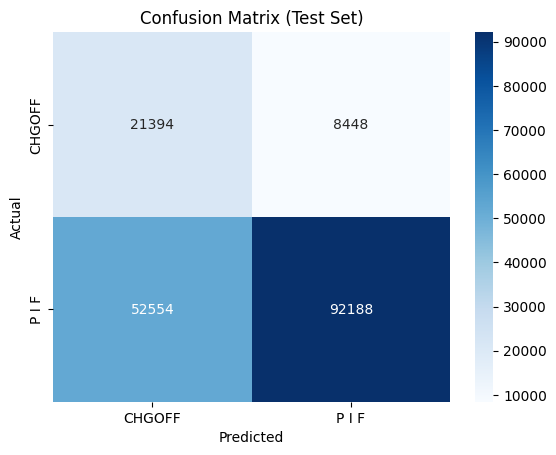

Total Net Profit/Loss: 747723508.55
Average Total Net Profit/Loss: 4282.89


In [55]:
# Step 1: Split Data into Features and Labels
X = df_new_franchise_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_franchise_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Removing the **'Franchise_Status'** feature did not have a significant impact on the model's performance. The metrics and net profit remained relatively unchanged, suggesting that **'Franchise_Status'** may not be a key factor in optimizing the QDA model.

##### QDA: Removing NAICS, Month, and Franchise Status

In this section, we will test the impact of removing all three columns (**'NAICS_U.S._Industry_Title'**, **'Month_Of_Approval'**, and **'Franchise_Status'**) from the model to assess whether excluding these features leads to any improvements in metrics or net profit.

In [59]:
columns_drop = ['Month_Of_Approval', 'NAICS_U.S._Industry_Title', 'Franchise_Status']
df_new_dropped = df_new.drop(columns = columns_drop)

In [60]:
df_new_dropped

,Loan_Term,Number_Of_Employees,Business_Type,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Region
0,84,4,New,Unknown,0,1,60000,1,Midwest
1,60,2,New,Unknown,0,1,40000,1,Midwest
2,180,7,Existing,Unknown,0,0,287000,1,Midwest
3,60,2,Existing,Unknown,0,1,35000,1,South
4,240,14,Existing,Unknown,0,0,229000,1,South
...,...,...,...,...,...,...,...,...,...
872914,60,6,Existing,Unknown,0,0,70000,1,Midwest
872915,60,6,Existing,Unknown,1,0,85000,1,Midwest
872916,108,26,Existing,Unknown,0,0,300000,1,West
872917,60,6,Existing,Unknown,0,1,75000,0,West


In [61]:
# Specify columns to exclude from dummy encoding
exclude_columns = [
    'Loan_Term', 
    'Number_Of_Employees', 
    'Revolving_Line_Of_Credit', 
    'Low_Documentation_Loan_Program', 
    'Disbursement_Gross', 
    'Loan_Status'
]

# Create dummy variables for all columns except those in exclude_columns
df_new_dropped_dummies = pd.get_dummies(df_new_dropped, columns=[col for col in df_new_dropped.columns if col not in exclude_columns], drop_first=True)

# Convert boolean columns to integer values (0 and 1)
for col in df_new_dropped_dummies.select_dtypes(include=['bool']).columns:
    df_new_dropped_dummies[col] = df_new_dropped_dummies[col].astype(int)

In [62]:
df_new_dropped_dummies

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,Business_Type_New,Business_Type_Unknown,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,Region_Northeast,Region_South,Region_West
0,84,4,0,1,60000,1,1,0,1,0,0,0,0
1,60,2,0,1,40000,1,1,0,1,0,0,0,0
2,180,7,0,0,287000,1,0,0,1,0,0,0,0
3,60,2,0,1,35000,1,0,0,1,0,0,1,0
4,240,14,0,0,229000,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
872914,60,6,0,0,70000,1,0,0,1,0,0,0,0
872915,60,6,1,0,85000,1,0,0,1,0,0,0,0
872916,108,26,0,0,300000,1,0,0,1,0,0,0,1
872917,60,6,0,1,75000,0,0,0,1,0,0,0,1


Training Set Metrics:
Accuracy: 0.6448
Precision: 0.8144
Recall: 0.6448
F1 Score: 0.6885

Test Set Metrics:
Accuracy: 0.6460
Precision: 0.8156
Recall: 0.6460
F1 Score: 0.6896

Specificity (Training Set): 0.7465
Specificity (Test Set): 0.7494


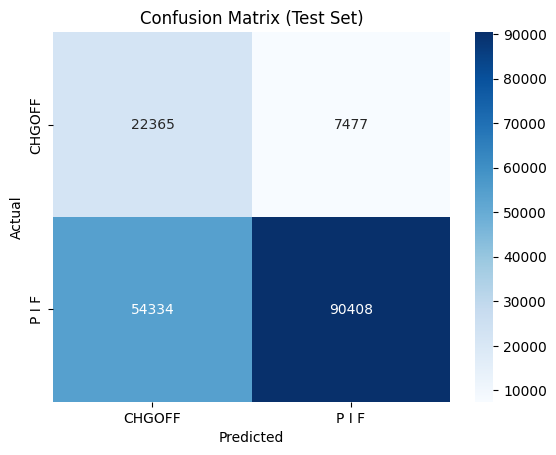

Total Net Profit/Loss: 786170263.75
Average Total Net Profit/Loss: 4503.11


In [63]:
# Step 1: Split Data into Features and Labels
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_dropped_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

# Step 6: Evaluation Metrics for Both Sets
# Training Set Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Testing Set Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Display the evaluation metrics for both sets
print("Training Set Metrics:")
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

print("\nTest Set Metrics:")
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')

# Step 7: Confusion Matrix for Both Sets
# For training set
cm_train = confusion_matrix(y_train, y_train_pred)
TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
specificity_train = TN_train / (TN_train + FP_train)

# For test set
cm_test = confusion_matrix(y_test, y_test_pred)
TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
specificity_test = TN_test / (TN_test + FP_test)

# Display Specificity for both sets
print(f'\nSpecificity (Training Set): {specificity_train:.4f}')
print(f'Specificity (Test Set): {specificity_test:.4f}')

# Plot confusion matrix for the test set as a heatmap
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CHGOFF', 'P I F'], yticklabels=['CHGOFF', 'P I F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Combine actual and predicted values into a DataFrame
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default
    
    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

# Merge df_new and results on the index or appropriate column
df_combined = df_new.join(results)

df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

# Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

# Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net:.2f}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net:.2f}")

Dropping **'Month_Of_Approval'**, **'NAICS_U.S._Industry_Title'**, and **'Franchise_Status'** resulted in the highest net profit compared to all other models tested. This suggests that removing these less statistically significant features allows the model to optimize profitability while maintaining strong performance metrics.

#### QDA Dropped 'Month_Of_Approval', 'NAICS_U.S._Industry_Title', and 'Franchise_Status': Performance Metrics

In [66]:
# Step 1: Split Data into Features and Labels
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)  # Independent variables
y = df_new_dropped_dummies['Loan_Status']  # Dependent variable

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Normalize Features using Z-Score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = qda.predict(X_train_scaled)
y_test_pred = qda.predict(X_test_scaled)

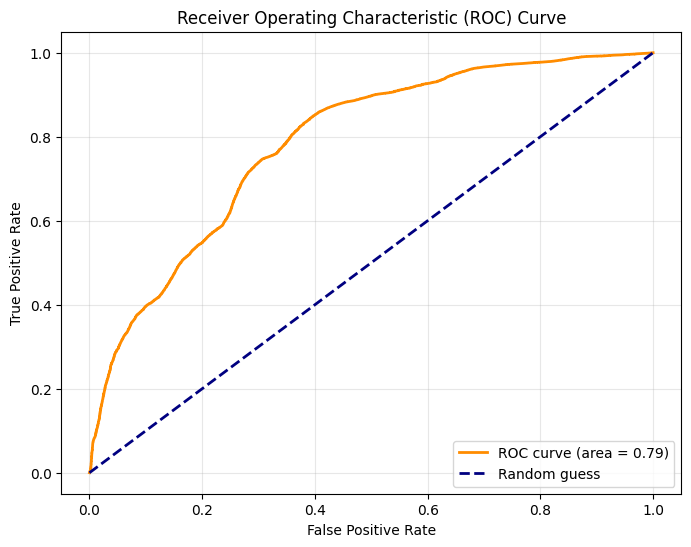

In [67]:
# Step 1: Calculate probabilities for ROC curve
y_test_proba = qda.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class

# Step 2: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

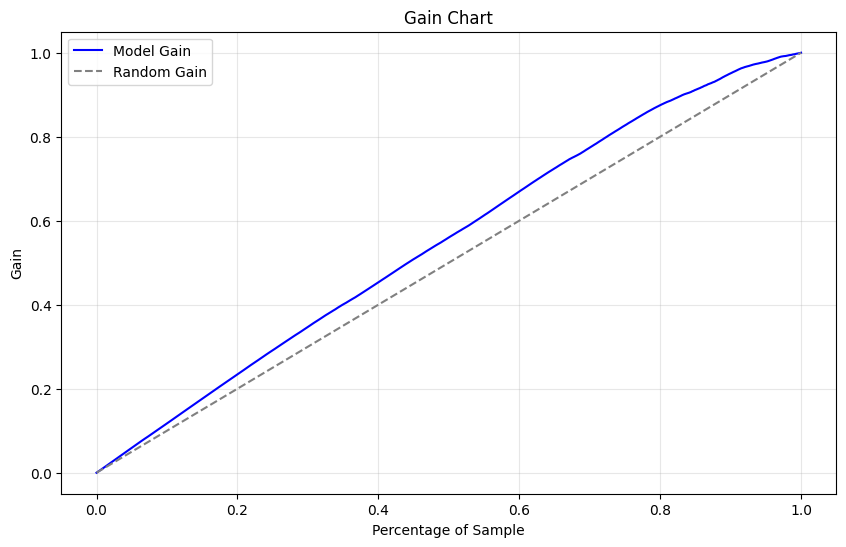

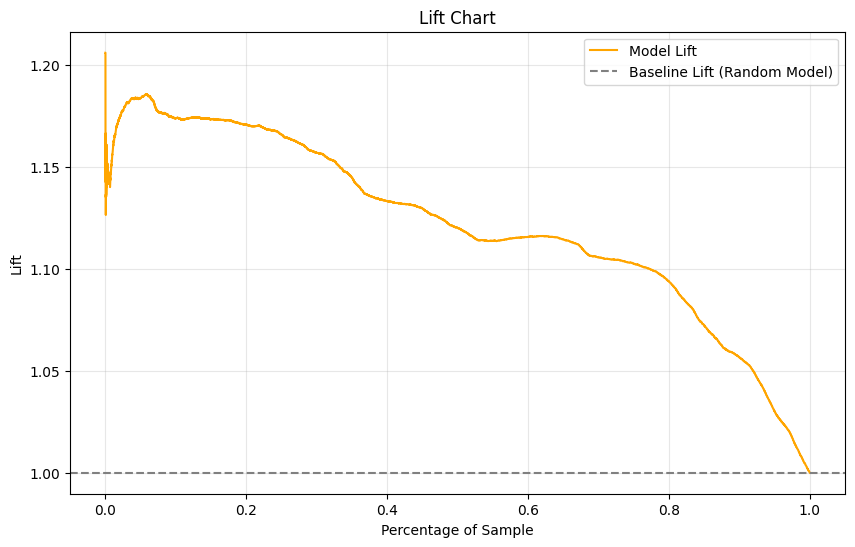

In [68]:
# Calculate probabilities for the positive class
y_test_proba = qda.predict_proba(X_test_scaled)[:, 1]  # Use QDA probabilities for the positive class

# Create a dataframe with actual and predicted probabilities
results = pd.DataFrame({
    'actual': y_test,
    'proba': y_test_proba
})

# Sort the dataframe by predicted probabilities in descending order
results = results.sort_values(by='proba', ascending=False).reset_index(drop=True)

# Add a cumulative sum of actual positives and total rows
results['cumulative_positives'] = results['actual'].cumsum()
results['cumulative_total'] = np.arange(1, len(results) + 1)

# Calculate Gain
total_positives = results['actual'].sum()
results['gain'] = results['cumulative_positives'] / total_positives

# Calculate Lift
results['lift'] = results['gain'] / (results['cumulative_total'] / len(results))

# Gain chart
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(results) + 1) / len(results), results['gain'], label='Model Gain', color='blue')
plt.plot([0, 1], [0, 1], label='Random Gain', linestyle='--', color='gray')  # Random model as reference
plt.title('Gain Chart')
plt.xlabel('Percentage of Sample')
plt.ylabel('Gain')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Lift chart
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(results) + 1) / len(results), results['lift'], label='Model Lift', color='orange')
plt.axhline(1, color='gray', linestyle='--', label='Baseline Lift (Random Model)')
plt.title('Lift Chart')
plt.xlabel('Percentage of Sample')
plt.ylabel('Lift')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

####  K-Fold Cross-Validation for QDA Dropped 'Month_Of_Approval', 'NAICS_U.S._Industry_Title', and 'Franchise_Status'

In [70]:
# Step 1: Define features and labels
X = df_new_dropped_dummies.drop('Loan_Status', axis=1)  # Features
y = df_new_dropped_dummies['Loan_Status']  # Labels

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
specificity_list = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    # Split data into train and test for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize features
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)
    
    # Train the QDA model
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train_fold_scaled, y_train_fold)
    
    # Make predictions
    y_test_pred_fold = qda.predict(X_test_fold_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_fold, y_test_pred_fold)
    precision = precision_score(y_test_fold, y_test_pred_fold)
    recall = recall_score(y_test_fold, y_test_pred_fold)
    f1 = f1_score(y_test_fold, y_test_pred_fold)
    
    # Specificity = TN / (TN + FP)
    cm = confusion_matrix(y_test_fold, y_test_pred_fold)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    
    # Append metrics to lists
    accuracy_list.append(round(accuracy, 4))
    precision_list.append(round(precision, 4))
    recall_list.append(round(recall, 4))
    f1_list.append(round(f1, 4))
    specificity_list.append(round(specificity, 4))

# Calculate average metrics across all folds
avg_accuracy = round(np.mean(accuracy_list), 4)
avg_precision = round(np.mean(precision_list), 4)
avg_recall = round(np.mean(recall_list), 4)
avg_f1 = round(np.mean(f1_list), 4)
avg_specificity = round(np.mean(specificity_list), 4)

# Print metrics for each fold
print("Metrics for each fold:")
for i in range(kf.get_n_splits()):
    print(f"Fold {i+1} - Accuracy: {accuracy_list[i]:.4f}, Precision: {precision_list[i]:.4f}, Recall: {recall_list[i]:.4f}, F1 Score: {f1_list[i]:.4f}, Specificity: {specificity_list[i]:.4f}")

# Print average metrics
print("\nAverage Metrics Across All Folds:")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")
print(f"Average Specificity: {avg_specificity}")

Metrics for each fold:
Fold 1 - Accuracy: 0.6614, Precision: 0.9245, Recall: 0.6441, F1 Score: 0.7592, Specificity: 0.7451
Fold 2 - Accuracy: 0.6216, Precision: 0.9219, Recall: 0.5938, F1 Score: 0.7223, Specificity: 0.7563
Fold 3 - Accuracy: 0.6464, Precision: 0.9217, Recall: 0.6266, F1 Score: 0.7460, Specificity: 0.7421
Fold 4 - Accuracy: 0.6459, Precision: 0.9236, Recall: 0.6244, F1 Score: 0.7451, Specificity: 0.7497
Fold 5 - Accuracy: 0.6575, Precision: 0.9239, Recall: 0.6394, F1 Score: 0.7558, Specificity: 0.7450

Average Metrics Across All Folds:
Average Accuracy: 0.6466
Average Precision: 0.9231
Average Recall: 0.6257
Average F1 Score: 0.7457
Average Specificity: 0.7476


After performing **K-Fold cross-validation** with **Quadratic Discriminant Analysis (QDA)**, the metrics (accuracy, precision, recall, F1 score, and specificity) were consistent across all folds. This indicates that the model generalizes well to unseen data, demonstrating no signs of overfitting.

#### Conclusions

In our analysis, we observed the following key points:
- **Linear discriminant models** did not perform well due to low specificity, which hindered the correct identification of negative cases (defaults).
- **Class weighting** was tested to address low specificity, which improved specificity but resulted in a decrease in other performance metrics such as accuracy, precision, recall, and F1 score.
- **Quadratic Discriminant Analysis (QDA)** outperformed all other models, achieving the highest net profit and delivering the best overall metrics across accuracy, precision, recall, and F1 score.
- **Feature removal analysis** was conducted on three columns with high p-values— **'Month_Of_Approval'**, **'NAICS_U.S._Industry_Title'**, and **'Franchise_Status'** —to determine their impact on model performance.
- **Removing all three columns** resulted in the best-performing model, with the highest net profit and strong metrics, suggesting that the columns were not adding value and were potentially causing noise.

In summary, the most optimal model was **QDA with the removal of the three columns**, which provided the best trade-off between predictive performance and profitability. This experiment highlights the importance of feature selection and the potential benefits of removing statistically insignificant features to improve model efficiency and outcomes.